In [127]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST,FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [128]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

## For trained weights

In [129]:
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST


class EmbeddingsCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_test_end(self, trainer, pl_module):
        #pl_module.
        trainer.logger.experiment.add_embedding(
            pl_module.test_embeddings,#pl_module.
            pl_module.test_targets,
            global_step=trainer.global_step)
        


class ANN(pl.LightningModule):
    def __init__(self,dataset_val1, data_dir='./'):
        super().__init__()
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.test_targets = []
        self.test_embeddings = torch.zeros((0, 50),
                                           dtype=torch.float32,
                                           device='cpu')
        self.test_predictions = []
        
        self.dataset_train=[]
        self.dataset_val=dataset_val1
        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128,50)
        self.fc3 = nn.Linear(50, self.num_classes)
        # Define PyTorch model

    def forward(self, x):
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.maxpool1(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.maxpool2(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = x.view(-1, 64 * 5 *5)
        x = self.fc1(x)
        x = self.fc2(x)
        y = self.fc3(F.relu(x))
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        x, y = batch
        embeddings, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.test_predictions.extend(preds.detach().cpu().tolist())
        self.test_targets.extend(y.detach().cpu().tolist())
        self.test_embeddings = torch.cat((self.test_embeddings, embeddings), 0)
        self.log('test_acc', acc)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        print('')

    def setup(self, dataset_train1,dataset_test1=[],dataset_val1=[], stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit':
            self.dataset_train, self.dataset_val,self.dataset_test=dataset_train1,dataset_val1,dataset_test1
           
        print(len(self.dataset_train))
        if stage == 'test':
            self.dataset_test = dataset_test1
                                  

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=32)


# Select Randomly 200 points to start AL training 

In [130]:
if __name__ == "__main__":
    
    data_dir='./'
    # download
    FashionMNIST(data_dir, train=True, download=True)
    FashionMNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = FashionMNIST(data_dir,train=True,transform=transform)
            
    dataset_train, dataset_val,remaining = random_split(dataset_full, [200, 10000,49800])
    dataset_train_original=copy.deepcopy(dataset_train)


    model = ANN(dataset_val)
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    embedding_callback = EmbeddingsCallback()
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='FashionMNIST-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_weights_only=True)
    trainer = pl.Trainer(
                         max_epochs=30,
                         progress_bar_refresh_rate=10,
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


200

200



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Shows some of FashionMNIST data

In [131]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

tensor([7, 3, 6, 6, 6, 5, 0, 6, 2, 3, 0, 0, 3, 7, 6, 7, 7, 8, 0, 5, 1, 4, 7, 6,
        7, 5, 9, 7, 6, 0, 9, 6])


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


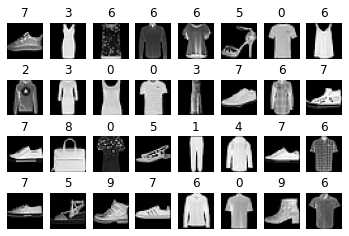

In [132]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

plt.figure()
for i in range(32):
    plt.subplot(4,8,i+1)
    arr=np.squeeze(data)
    plt.imshow(my_sample[0][i][0], cmap='gray')
    plt.axis('off')
    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

## prepare_test_embeddings

In [133]:
def prepare_test_embeddings(dataset_train):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(dataset_train, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds)#.detach().cpu().tolist())
        test_targets.extend(y)#.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    return test_embeddings,test_targets,test_predictions,final_test_acc
#test_embeddings,test_targets,final_test_acc=prepare_test_embeddings(dataset_train)

In [134]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Initial Testing accuracy:   0.7333


# Kmeans ++

In [135]:
def all_list(test_embeddings,test_targets,data):
    test_embeddings=test_embeddings
    test_targets=test_targets
    list1,data1=[],[]
    list2,data2=[],[]
    list3,data3=[],[]
    list4,data4=[],[]
    list5,data5=[],[]
    list6,data6=[],[]
    list7,data7=[],[]
    list8,data8=[],[]
    list9,data9=[],[]
    list10,data10=[],[]
    i=0
    for embeddings in test_embeddings:
        if test_targets[i]==0:
            list1.append(embeddings)
            data1.append(data[i])
        if test_targets[i]==1:
            list2.append(embeddings)
            data2.append(data[i])
        if test_targets[i]==2:
            list3.append(embeddings)
            data3.append(data[i])
        if test_targets[i]==3:
            list4.append(embeddings)
            data4.append(data[i])
        if test_targets[i]==4:
            list5.append(embeddings)
            data5.append(data[i])
        if test_targets[i]==5:
            list6.append(embeddings)
            data6.append(data[i])
        if test_targets[i]==6:
            list7.append(embeddings)
            data7.append(data[i])
        if test_targets[i]==7:
            list8.append(embeddings)
            data8.append(data[i])
        if test_targets[i]==8:
            list9.append(embeddings)
            data9.append(data[i])
        if test_targets[i]==9:
            list10.append(embeddings)
            data10.append(data[i])
        i=i+1
    all_lists=[]
    all_data=[]
    list1,data1=np.array(list1),np.array(data1)
    all_lists.append(list1),all_data.append(data1)
    
    list2,data2=np.array(list2),np.array(data2)
    all_lists.append(list2),all_data.append(data2)
    
    list3,data3=np.array(list3),np.array(data3)
    all_lists.append(list3),all_data.append(data3)
    
    list4,data4=np.array(list4),np.array(data4)
    all_lists.append(list4),all_data.append(data4)
    
    list5,data5=np.array(list5),np.array(data5)
    all_lists.append(list5),all_data.append(data5)
    
    list6,data6=np.array(list6),np.array(data6)
    all_lists.append(list6),all_data.append(data6)
    
    list7,data7=np.array(list7),np.array(data7)
    all_lists.append(list7),all_data.append(data7)
    
    list8,data8=np.array(list8),np.array(data8)
    all_lists.append(list8),all_data.append(data8)
    
    list9,data9=np.array(list9),np.array(data9)
    all_lists.append(list9),all_data.append(data9)
    
    list10,data10=np.array(list10),np.array(data10)
    all_lists.append(list10),all_data.append(data10)
    
    print(list10.shape, len(list9),len(all_lists))
    return all_lists,all_data
#all_lists=all_list(test_embeddings2,test_targets2)
#all_lists=all_list(all_np,labels)

Prepare test embeddings for all data  

# extract embeddings of 200 training data to get the center points

In [136]:
len(dataset_train)

200

In [137]:
dataset_full2, remaning = random_split(dataset_train, [len(dataset_train),0])

In [138]:
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(dataset_train)

In [139]:
temb_test_embeddings_copy=test_embeddings
dataset_full2_copy=dataset_full2
test_targets_copy=test_targets
test_predictions_copy=test_predictions

# visualize the ditribution of Random 200 points 

In [140]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.003s...
[t-SNE] Computed neighbors for 200 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 7.967963
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.106194
[t-SNE] KL divergence after 1000 iterations: 0.205152


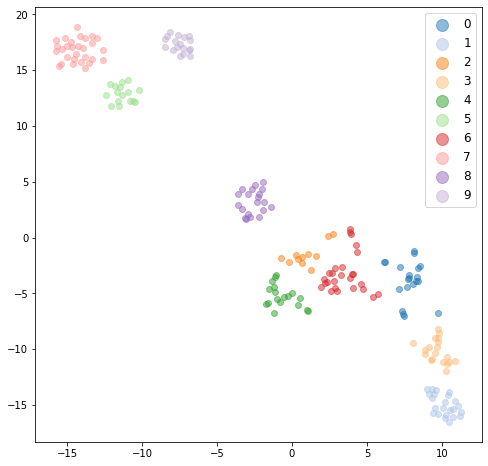

In [141]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# To Get only the correct data prediction  

In [142]:
def get_correct_embeddings(temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy):
    c=0
    print(len(temb_test_embeddings_copy))
    for i in range(len(temb_test_embeddings_copy)):
        try:
            if test_targets_copy[i]!=test_predictions_copy[i]:
                print(i)
                temb_test_embeddings_copy=np.delete(temb_test_embeddings_copy,i-c,axis=0)
                dataset_full2_copy=np.delete(dataset_full2_copy,i-c,axis=0)
                test_targets_copy=np.delete(test_targets_copy,i-c,axis=0)
                test_predictions_copy=np.delete(test_predictions_copy,i-c,axis=0)
                c=c+1
        except:
            print("")
    print(len(temb_test_embeddings_copy))
    return temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy
print(len(temb_test_embeddings_copy))

200


In [143]:
test_embeddings=temb_test_embeddings_copy
dataset_full2=dataset_full2_copy
test_targets=test_targets_copy
dataset_train_original2=dataset_full2

In [144]:
all_lists,all_data_points=all_list(test_embeddings,test_targets,dataset_full2)

(18, 50) 20 10


<ipython-input-135-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-135-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-135-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [145]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [146]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(test_embeddings) 
kmeans.labels_

array([2, 1, 9, 3, 5, 6, 5, 0, 8, 3, 7, 4, 4, 6, 8, 9, 2, 2, 8, 6, 6, 4,
       2, 0, 0, 2, 3, 8, 2, 2, 6, 5, 8, 9, 8, 5, 5, 7, 3, 2, 0, 1, 6, 5,
       9, 0, 2, 2, 7, 1, 5, 7, 6, 9, 2, 5, 3, 4, 9, 4, 5, 9, 8, 8, 6, 8,
       5, 5, 5, 1, 9, 9, 5, 8, 9, 9, 8, 6, 5, 6, 6, 7, 9, 1, 2, 0, 6, 9,
       6, 1, 3, 6, 5, 9, 3, 9, 3, 0, 1, 9, 1, 8, 5, 7, 7, 5, 9, 8, 0, 8,
       6, 1, 3, 4, 2, 7, 7, 3, 0, 6, 6, 0, 5, 8, 8, 7, 3, 7, 6, 1, 7, 5,
       0, 2, 9, 3, 2, 5, 1, 6, 3, 6, 0, 0, 0, 1, 6, 2, 4, 6, 3, 0, 8, 6,
       6, 9, 3, 1, 6, 8, 1, 7, 2, 2, 5, 7, 7, 4, 2, 7, 2, 3, 1, 8, 6, 9,
       1, 6, 2, 5, 9, 7, 0, 0, 2, 7, 7, 4, 5, 7, 9, 2, 3, 6, 6, 5, 3, 0,
       5, 5])

In [147]:
len(kmeans.cluster_centers_)

10

In [148]:
all_clusters=kmeans.cluster_centers_

In [149]:
import math
import scipy.spatial as sp
import numpy as np
def get_dist(a,b):
    reslt=sp.distance.cosine(a,b)
    return reslt

In [150]:
len(test_embeddings)

200

# assign center point for each class 

In [151]:
center_classes=[]
for clas in all_lists:
    for cluster in all_clusters:
        p=cluster
        n = len(clas)
        dist = math.inf #(infinity)
        temb_test_embeddings=clas#.copy()
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
    center_classes.append(np1)
    indx=np.where(all_clusters==cluster)
    all_clusters=np.delete(all_clusters,indx[0][0],axis=0)
    print(len(all_clusters))
len(center_classes)

9
8
7
6
5
4
3
2
1
0


10

# get 10 neighbours for each class to perform (200 initial points)

In [152]:
points_class0=[]
points_class1=[]
points_class2=[]
points_class3=[]
points_class4=[]
points_class5=[]
points_class6=[]
points_class7=[]
points_class8=[]
points_class9=[]
all_points=[]
all_points.append(points_class0)
all_points.append(points_class1)
all_points.append(points_class2)
all_points.append(points_class3)
all_points.append(points_class4)
all_points.append(points_class5)
all_points.append(points_class6)
all_points.append(points_class7)
all_points.append(points_class8)
all_points.append(points_class9)


points_dist0=[]
points_dist1=[]
points_dist2=[]
points_dist3=[]
points_dist4=[]
points_dist5=[]
points_dist6=[]
points_dist7=[]
points_dist8=[]
points_dist9=[]
all_dist=[]
all_dist.append(points_dist0)
all_dist.append(points_dist1)
all_dist.append(points_dist2)
all_dist.append(points_dist3)
all_dist.append(points_dist4)
all_dist.append(points_dist5)
all_dist.append(points_dist6)
all_dist.append(points_dist7)
all_dist.append(points_dist8)
all_dist.append(points_dist9)

In [153]:
all_np=[]
for lab in range(10):
    p=center_classes[lab]
    n = len(all_lists[lab])
    dist = math.inf #(infinity)
    temb_test_embeddings=all_lists[lab]#kmeans.labels_
    for c in range(10): 
        n = len(temb_test_embeddings)
        dist = math.inf
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
        all_np.append(np1)
        indx=np.where(temb_test_embeddings==np1)
        print(len(temb_test_embeddings))
        
        temb_test_embeddings=np.delete(temb_test_embeddings,indx[0][0],axis=0)
        dataset_train_original2=np.delete(dataset_train_original2,indx[0][0],axis=0)
        
        
    n = len(temb_test_embeddings)
    dist = math.inf
    for i in range(n):
        d = get_dist(p,temb_test_embeddings[i])
        all_points[lab].append(all_data_points[lab][i])
        all_dist[lab].append(d)
len(all_np)

20
19
18
17
16
15
14
13
12
11
23
22
21
20
19
18
17
16
15
14
11
10
9
8
7
6
5
4
3
2
19
18

C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)



17
16
15
14
13
12
11
10
18
17
16
15
14
13
12
11
10
9
16
15
14
13
12
11
10
9
8
7
26
25
24
23
22
21
20
19
18
17
29
28
27
26
25
24
23
22
21
20
20
19
18
17
16
15
14
13
12
11
18
17
16
15
14
13
12
11
10
9


100

# get the original images (as core_data) corrosponding to the 100 center points

In [154]:
indx=np.where(test_embeddings==all_np[0])
core_data1=dataset_full2[indx[0][0]]
core_data1,t=random_split([core_data1],[1,0])
core_data1=tuple(core_data1)
for point in all_np[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    core_data1=torch.utils.data.ConcatDataset([arr,core_data1])

In [155]:
core_data=core_data1
len(core_data)

100

# Embeddings of 100 core-set

In [156]:
test_embeddings2,test_targets2,test_predictions2,final_test_acc2=prepare_test_embeddings(core_data)

In [157]:
test_embeddings2,core_data,test_targets2,test_predictions2=get_correct_embeddings(test_embeddings2,core_data,test_targets2,test_predictions2)

100
100


# visualize the ditribution of 100 core_data 

In [158]:
tsne = TSNE(2, verbose=1)
tsne_proj_core = tsne.fit_transform(test_embeddings2)
#tsne_proj = tsne.fit_transform(core_data.datasets[1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 23.778515
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.810768
[t-SNE] KL divergence after 1000 iterations: 0.141110


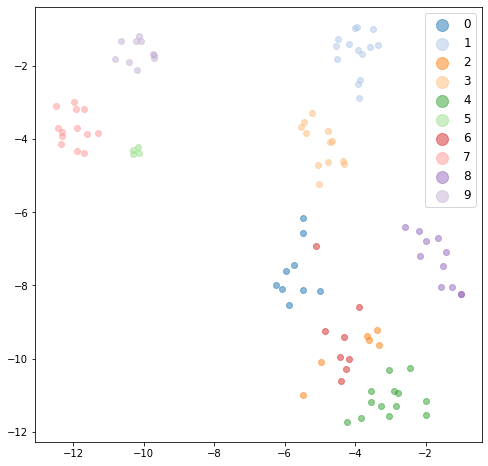

In [159]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets2==lab
    ax.scatter(tsne_proj_core[indices,0],tsne_proj_core[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### **For one class SVM**

In [160]:
all_lists,_=all_list(test_embeddings2,test_targets2,core_data)

(10, 50) 11 10


<ipython-input-135-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-135-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-135-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [161]:
X_train=np.concatenate((all_lists[9],all_lists[8],all_lists[7],all_lists[6],all_lists[5],all_lists[4],all_lists[3],all_lists[2],all_lists[1],all_lists[0]),axis=0)
len(X_train)

100

In [162]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'scale').fit(X_train)

In [163]:
def do_predict(dataset_test):
    transform = transforms.Compose([transforms.ToTensor()])
    data=dataset_test#dataset_test
    dataloader = DataLoader(data, batch_size=32)
    test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    train_acc = np.sum(test_predictions == test_targets)
    final_train_acc = train_acc/len(test_embeddings)
    final_train_acc
    return final_train_acc,test_targets,test_embeddings

In [164]:
dataset_full2 = tuple([tuple(e) for e in dataset_full2])
len(dataset_full2)

200

# Just to visualize outlier prediction (Take one example)

In [165]:
dd1,remaning = random_split(dataset_full2, [100,len(dataset_full2)-100])
# do prediction 
_,t_targets3,t_embeddings3=do_predict(dd1)

In [166]:
len(dd1)

100

In [167]:
prediction = one_class_svm.predict(t_embeddings3)
prediction = [1 if i==-1 else 0 for i in prediction]

In [168]:
all_prediction=prediction

# to extract prediction by one svm 

In [169]:
def extract_prediction_by_svm(embedding):
    all_prediction=[]
    prediction2=one_class_svm.predict(embedding)
    prediction2 = [1 if i==-1 else 0 for i in prediction2]
    len(prediction2)
    return prediction2#,alldata

# to extract outliers (exact images)from the corosponding all_prediction  

In [170]:
all_outliers=torch.utils.data.Subset([],[])

In [171]:
def extract_outliers_from_svm(all_prediction,alldata):
    all_outliers=torch.utils.data.ConcatDataset([[],[]])
   
    out1=torch.utils.data.ConcatDataset([[],[]])
    for i in range(len(all_prediction)):
        if all_prediction[i]==1:
            out1=torch.utils.data.ConcatDataset([[(alldata[i][0],alldata[i][1])],out1])
    arr,t=random_split(out1,[len(out1),0])
    all_outliers=torch.utils.data.ConcatDataset([arr,all_outliers])  
    print(len(all_outliers))
    return all_outliers
temb_training=extract_outliers_from_svm(all_prediction,dd1)

16


In [172]:
temb_training

# visualization of OneSvm 

In [173]:
core_data=tuple([tuple(e) for e in core_data])

In [174]:
temb_training=torch.utils.data.ConcatDataset([core_data,temb_training])#core_data
test_embeddings4,test_targets4,_,_=prepare_test_embeddings(temb_training)
print(len(test_embeddings4))

116


In [175]:
#do predict on one SVM
prediction2 = one_class_svm.predict(test_embeddings4)
# Change the anomalies' values to make it consistent with the true values
prediction2 = [1 if i==-1 else 0 for i in prediction2]
#print("The result of outlier is ",prediction)

In [176]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings4)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 116 samples in 0.000s...
[t-SNE] Computed neighbors for 116 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 116 / 116
[t-SNE] Mean sigma: 22.268309
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.011719
[t-SNE] KL divergence after 1000 iterations: 0.144158


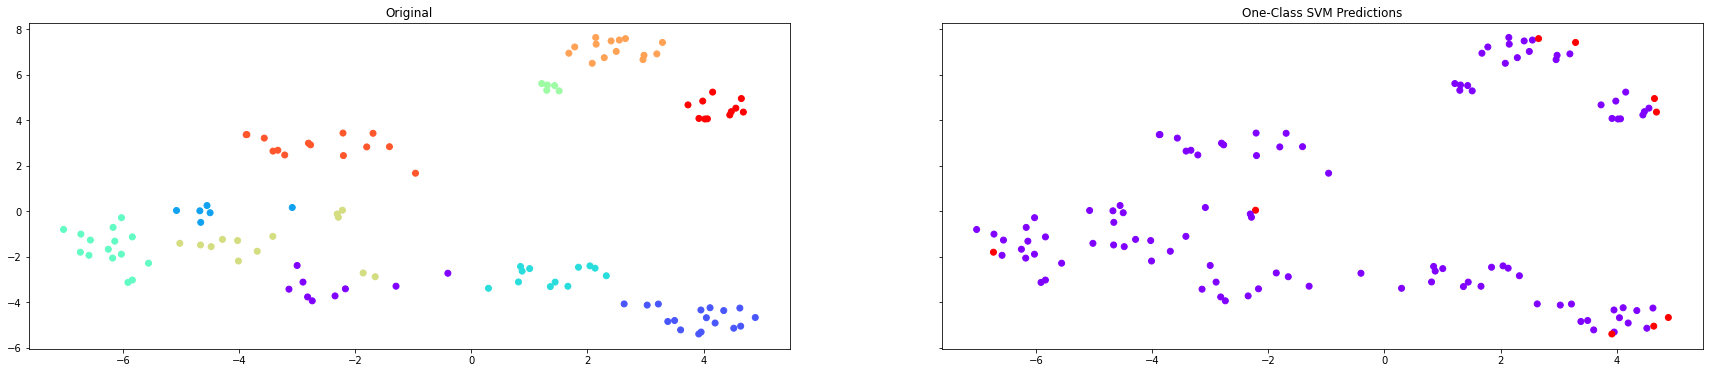

In [177]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(tsne_proj, columns=['feature1', 'feature2'])
df_test['y_test'] = test_targets4#test_targets4
df_test['one_class_svm_prediction'] = prediction2


df_core = pd.DataFrame(tsne_proj_core, columns=['feature1', 'feature2'])
df_core['y_test'] = test_targets2

fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(30,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')


# initial training with core data to prepare IncLearning

In [178]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)

In [179]:
len(model.dataset_train)

200

In [180]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)

In [181]:
final_test_acc

0.7333

In [182]:
dataset_full2_copy=remaining
dataset_train=dataset_train_original#core_data

# give an outlier score for all 49800 unlabeled training data and then take the highest 100 points in each round

In [183]:
remaining=dataset_full2_copy
dataset_train=dataset_train_original

In [184]:
import time
start_time = time.time()
CNN_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [185]:
pred_list_val=[]
pred_list_train=[]
pred_list_test=[]
all_outliers=[]
len_outliers=[]
Times=[]

In [186]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
pred_list_test.append(final_test_acc)

In [187]:
pred_list_val.append(trainer.callback_metrics["val_acc"])
pred_list_train.append(trainer.callback_metrics["train_acc"])
pred_list_test.append(final_test_acc)
Times.append(CNN_time)
len_outliers.append(200)

In [188]:
one_class_svm = OneClassSVM(nu=0.00005, kernel = 'poly', gamma ='auto').fit(test_embeddings)

In [189]:
kernel = 'poly'
gamma = 'auto'
NU=0.00001

roud=0
nu_out=300
while final_test_acc<=0.86:
#for c in range(2):
    start_time = time.time()
    #one_class_svm = OneClassSVM(nu=0.5, kernel = 'rbf', gamma = 'scale').fit(X_train)
    _,_,test_embeddings=do_predict(remaining)
    whole_prediction=one_class_svm.predict(test_embeddings)
    Scores=one_class_svm.score_samples(test_embeddings)
    len_out=0
    for out1 in whole_prediction:
        if out1==1:
            len_out=len_out+1
    print(len_out)
    df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
    df_remaining.sort_values(by=['Score'], inplace=True,ascending=True)
    Whole_outliers=torch.utils.data.ConcatDataset([[],[]])
    
    
    for i in range(nu_out):
        Whole_outliers=torch.utils.data.ConcatDataset([[(df_remaining['Remaining'][i][0],df_remaining['Remaining'][i][1])]
                                                   ,Whole_outliers])
        indx=np.where(test_embeddings==df_remaining['embeddings'][i])
        remaining=np.delete(remaining,indx[0][0],axis=0)
    remaining=tuple([tuple(e) for e in remaining])
    remaining=torch.utils.data.ConcatDataset([remaining,[]])
    
    dataset_train=torch.utils.data.ConcatDataset([Whole_outliers,dataset_train])
    print('All Remaining',len(remaining))
    #print('dataset_train_temp>>>>>>>>',len(dataset_train_temb))
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    trainer = pl.Trainer(
                         max_epochs=30,
                         progress_bar_refresh_rate=10,
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)
    
    print('Gooooood their is valuable data')
    len_outliers.append(nu_out)


    #print(len(outlier),'......',i)
    print(trainer.callback_metrics["val_acc"])
    pred_list_val.append(trainer.callback_metrics["val_acc"])
    pred_list_train.append(trainer.callback_metrics["train_acc"])

    
    _,_,_,final_test_acc=prepare_test_embeddings(data_test)
    pred_list_test.append(final_test_acc)
    # repeat one SVM
    #prepaire the new test_embeddings


    test_embeddings,test_targets,_,_=prepare_test_embeddings(dataset_train)
    print(len(test_embeddings),final_test_acc)
    
    one_class_svm = OneClassSVM(nu=NU, kernel = kernel, gamma =gamma).fit(test_embeddings)
    CNN_time = time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))
    Times.append(CNN_time)
    if roud>=0:
        nu_out=250
    roud=roud+1

49165


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49500
500

500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8101)
500 0.8127
--- 532.7858111858368 seconds ---
49053


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49250
750

750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8189)
750 0.818
--- 518.851438999176 seconds ---
48738


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49000
1000

1000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8211)
1000 0.8208
--- 535.5419020652771 seconds ---
48462


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48750
1250

1250



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8224)
1250 0.8205
--- 557.7696015834808 seconds ---
48331


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48500
1500

1500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8263)
1500 0.8235
--- 577.722359418869 seconds ---
48179


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48250
1750

1750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8301)
1750 0.8279
--- 609.2414679527283 seconds ---
47754


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48000
2000

2000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8334)
2000 0.8328
--- 619.8382272720337 seconds ---
47471


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47750
2250

2250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8333)
2250 0.8359
--- 629.2663254737854 seconds ---
46685


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47500
2500

2500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8438)
2500 0.8383
--- 654.4780406951904 seconds ---
45897


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47250
2750

2750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8467)
2750 0.837
--- 660.1075792312622 seconds ---
44852


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47000
3000

3000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8462)
3000 0.8383
--- 659.1508500576019 seconds ---
44249


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46750
3250

3250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8453)
3250 0.8434
--- 710.5658347606659 seconds ---
44345


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46500
3500

3500


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8430)
3500 0.8433
--- 764.2580690383911 seconds ---
45506


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46250
3750

3750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8463)
3750 0.8437
--- 1100.778388261795 seconds ---
45112


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46000
4000

4000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8470)
4000 0.8432
--- 1114.4732854366302 seconds ---
44306


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 45750
4250

4250



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8467)
4250 0.8446
--- 806.0484228134155 seconds ---
44068


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 45500
4500

4500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8455)
4500 0.8459
--- 769.7333381175995 seconds ---
43197


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 45250
4750

4750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8479)
4750 0.8494
--- 791.6487197875977 seconds ---
43641


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 45000
5000

5000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8467)
5000 0.8494
--- 808.7680740356445 seconds ---
44102


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 44750
5250

5250



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8457)
5250 0.8493
--- 825.8060541152954 seconds ---
44244


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 44500
5500

5500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8509)
5500 0.8471
--- 846.1003170013428 seconds ---
43496


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 44250
5750

5750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8483)
5750 0.8479
--- 858.2861144542694 seconds ---
43721


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 44000
6000

6000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8482)
6000 0.8488
--- 882.0738065242767 seconds ---
43445


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 43750
6250

6250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8516)
6250 0.8545
--- 898.841705083847 seconds ---
43088


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 43500
6500

6500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8517)
6500 0.8482
--- 921.5594010353088 seconds ---
42949


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 43250
6750

6750


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8514)
6750 0.8532
--- 941.4657251834869 seconds ---
42660


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 43000
7000

7000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8551)
7000 0.8544
--- 952.0292036533356 seconds ---
42603


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 42750
7250

7250



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8527)
7250 0.8519
--- 978.4260323047638 seconds ---
42283


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 42500
7500

7500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8565)
7500 0.8522
--- 995.0465214252472 seconds ---
42142


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 42250
7750

7750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8529)
7750 0.8506
--- 886.6940031051636 seconds ---
41855


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 42000
8000

8000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8518)
8000 0.8496
--- 734.9971296787262 seconds ---
41841


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 41750
8250

8250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8574)
8250 0.8521
--- 748.0475168228149 seconds ---
41512


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 41500
8500

8500


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8559)
8500 0.8499
--- 749.3577628135681 seconds ---
41374


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 41250
8750

8750


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8566)
8750 0.8503
--- 764.5254967212677 seconds ---
41138


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 41000
9000

9000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8550)
9000 0.8466
--- 782.3284542560577 seconds ---
40959


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 40750
9250

9250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8572)
9250 0.852
--- 788.7864661216736 seconds ---
40674


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 40500
9500

9500


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8380)
9500 0.8435
--- 802.2815778255463 seconds ---
40456


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 40250
9750

9750


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8433)
9750 0.8396
--- 811.7260980606079 seconds ---
40174


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 40000
10000

10000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8533)
10000 0.8464
--- 838.997138261795 seconds ---
39925


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 39750
10250

10250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8563)
10250 0.8492
--- 838.5925025939941 seconds ---
39700


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 39500
10500

10500


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8563)
10500 0.8519
--- 855.8569436073303 seconds ---
39452


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 39250
10750

10750


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8538)
10750 0.8501
--- 867.8573896884918 seconds ---
39206


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 39000
11000

11000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8537)
11000 0.8512
--- 884.5723555088043 seconds ---
38977


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 38750
11250

11250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8521)
11250 0.8477
--- 893.3040292263031 seconds ---
38693


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 38500
11500

11500


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8598)
11500 0.8532
--- 901.4202878475189 seconds ---
38463


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 38250
11750



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)



11750


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8506)
11750 0.8474
--- 912.9513759613037 seconds ---
38230


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 38000
12000

12000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8543)
12000 0.8511
--- 928.651529788971 seconds ---
37974


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 37750
12250

12250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8618)
12250 0.8589
--- 945.1385200023651 seconds ---
37720


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 37500
12500

12500


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8614)
12500 0.8595
--- 956.0740196704865 seconds ---
37474


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 37250
12750

12750


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8656)
12750 0.8572
--- 965.8075203895569 seconds ---
37207


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 37000
13000

13000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8633)
13000 0.8573
--- 985.1997168064117 seconds ---
36979


<ipython-input-189-5ef89fdcbe20>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 36750
13250

13250


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.8641)
13250 0.8607
--- 1046.8972449302673 seconds ---


In [ ]:
all_data=[pred_list_train[:],pred_list_val[:],pred_list_test[:],len_outliers[:],Times[:]]
all_info=pd.DataFrame(all_data)
all_info=all_info.T
all_info.columns=['Train ACC','Valid ACC','Test ACC','Length of outliers','Time']
all_info

In [191]:
all_info.to_csv('Result of (AL with CNN) over Fashion.csv')